# 2. faza - predspracovanie
# Daniel Kavuliak - 50%, Bettina Pinkeova - 50%

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy import stats
from sklearn.base import TransformerMixin
from datetime import datetime
from sklearn import linear_model

%matplotlib inline

In [2]:
class MyTidy:
    def tidy_personal(self, personal):
        personal = personal.drop(columns='Unnamed: 0')
        
        personal['address'] = personal['address'].str.replace('\r\n', ', ')
        personal[['street', 'city', 'postal_code']] = personal.address.str.split(', ', expand=True)
        personal = personal.drop(columns='address')
        personal.loc[personal['postal_code'].isnull(), 'postal_code'] = personal.loc[personal['postal_code'].isnull(), 'city']
        personal.loc[personal['postal_code'] == personal['city'], 'city'] = np.nan
        
        personal.loc[personal['date_of_birth'].str.len() > 10, 'date_of_birth'] = personal.loc[personal['date_of_birth'].str.len() > 10, 'date_of_birth'].apply(lambda x: x[:10])
        personal['date_of_birth'] = pd.to_datetime(personal.date_of_birth)
        personal['date_of_birth'] = personal['date_of_birth'].dt.strftime('%d-%m-%y')
        
        for i in range(len(personal)):
            tmp = str(personal.iloc[i, 3])
            if personal.iloc[i, 1] > 19:
                tmp = tmp[0:6] + '19' + tmp[6:]
            else:
                tmp = tmp[0:6] + '20' + tmp[6:]
            personal.iloc[i, 3] = datetime.strptime(tmp, '%d-%m-%Y').date()
        
        tmp = pd.Series(np.zeros(len(personal)))
        tmp[personal[personal['city'].isnull()].index] = 1
        personal['city_was_nan'] = tmp
        
        return personal
    
    
    def tidy_other(self, other):
        other = other.drop(columns='Unnamed: 0')
        
        other['address'] = other['address'].str.replace('\r\n', ', ')
        other[['street', 'city', 'postal_code']] = other.address.str.split(', ', expand=True)
        other = other.drop(columns='address')
        other.loc[other['postal_code'].isnull(), 'postal_code'] = other.loc[other['postal_code'].isnull(), 'city']
        other.loc[other['postal_code'] == other['city'], 'city'] = np.nan
        
        other.personal_info = other.personal_info.str.replace('|', ',')
        other.personal_info = other.personal_info.str.replace(' -- ', ',')
        other.personal_info = other.personal_info.str.replace('\r\r\n', ',')
        other[['job', 'country', 'status', 'employment','race']] = other.personal_info.str.split(',', expand=True)
        other = other.drop(columns='personal_info')
        
        pregnant = {'FALSE': False, 'f': False, 'F': False, 'TRUE': True, 'T': True, 't': True}
        other = other.replace({'pregnant': pregnant})
        
        other.loc[other['job'] == '?', 'job'] = np.nan
        other.loc[other['country'] == '?', 'country'] = np.nan
        other.loc[other['employment'] == '?', 'employment'] = np.nan
        other.loc[other['race'] == '??', 'race'] = np.nan
        other.loc[other['race'] == 'nan', 'race'] = np.nan
        
        other['job'] = other['job'].str.replace('-', '_')
        
        other['education'] = other['education'].str.strip()
        other['relationship'] = other['relationship'].str.strip()
        other['income'] = other['income'].str.strip()
        
        tmp = pd.Series(np.zeros(len(other)))
        tmp[other[other['city'].isnull()].index] = 1
        other['city_was_nan'] = tmp
        
        duplicated = other[other['name'].duplicated()]['name']
        tmp = other[other['name'].isin(duplicated)].rename_axis('index').sort_values(['name', 'index']).index
        for i in range(0, len(tmp), 2):
            for j in range(27):
                if isinstance(other.iloc[tmp[i], j], str):
                    continue
                if np.isnan(other.iloc[tmp[i], j]):
                    other.iloc[tmp[i], j] = other.iloc[tmp[i + 1], j]
                    
        other = other.drop(duplicated.index, axis=0)
        other = other.reset_index(drop=True)
        
        return other

In [3]:
class MyImputer(TransformerMixin):
    
    def __init__(self, missing_value=np.nan):
        self.missing_value = missing_value
        self.value = []
        
    def _get_mask(self, X, value_to_mask):
        if np.isnan(value_to_mask):
            return X.isnull()
        else:
            return np.equal(X, value_to_mask)
        
    def fit(self, df, y=None):
        column_name = df.columns
        dictionary = {'income': 'job',
                      'relationship': 'status',
                      'status': 'relationship',
                      'education': 'education-num',
                      'education-num': 'education',
                      'hours-per-week': 'employment'}
        
        for i in column_name:
            mask = self._get_mask(df[i], self.missing_value)
            
            if len(df[mask]) == 0:
                continue
            
            if df[i].dtype == 'float64' and i != 'std_glucose' and i != 'class' and i != 'hours-per-week':
                self.value.append(np.median(df.loc[~mask, i]))
            elif i == 'std_glucose':
                model = linear_model.LinearRegression()
                
                X_train = np.array(df.loc[~other['std_glucose'].isnull(), 'mean_glucose'].dropna()).reshape(-1, 1)
                y_train = np.array(df.loc[~other['std_glucose'].isnull(), 'std_glucose'].dropna()).reshape(-1, 1)
                X_test = np.array(df.loc[other['std_glucose'].isnull(), 'mean_glucose'].dropna()).reshape(-1, 1)
                
                model.fit(X=X_train, y=y_train)
                result = model.predict(X_test)
                
                result = result.reshape(len(result)).tolist()
                self.value.append(result)
            elif i == 'race' or i == 'employment' or i == 'job' or i == 'class' or i == 'city' or i == 'country':
                self.value.append(df.loc[~mask, i].mode()[0])
            else:
                tmp = df.loc[df[i].isnull(), [i, dictionary[i]]]
                
                self.value.append([])
                for j in range(len(tmp)):
                    if isinstance(tmp.iloc[j, 1], str):
                        self.value[-1].append(df.loc[df[tmp.columns[1]] == tmp.iloc[j, 1], i].mode()[0])
                    elif not np.isnan(tmp.iloc[j, 1]):
                        self.value[-1].append(df.loc[df[tmp.columns[1]] == tmp.iloc[j, 1], i].mode()[0])
                    else:
                        self.value[-1].append(df[i].mode()[0])
        
        return self
        
    
    def transform(self, df):
        column_name = df.columns
        
        if 'education-num' in column_name:
            df.loc[df['education-num'] > 99, 'education-num'] /= 100
            df.loc[df['education-num'] < 0, 'education-num'] /= -100
            
        if 'pregnant' in column_name:
            df['pregnant'] = df['pregnant'].astype(bool)
        
        k = 0
        for i in range(len(column_name)):
            mask = self._get_mask(df[column_name[i]], self.missing_value)
            
            if len(df[mask]) == 0:
                continue
            
            if df[column_name[i]].dtype == 'float64' and column_name[i] != 'std_glucose' and column_name[i] != 'class' and column_name[i] != 'hours-per-week':
                df[column_name[i]][mask] = self.value[k]
            elif column_name[i] == 'race' or column_name[i] == 'employment' or column_name[i] == 'job' or column_name[i] == 'city' or column_name[i] == 'country':
                df[column_name[i]][mask] = self.value[k]
            elif column_name[i] == 'class':
                df[column_name[i]][mask] = self.value[k]
                df[column_name[i]] = df[column_name[i]].astype(bool)
            else:
                tmp = df.loc[df[column_name[i]].isnull()].index
                
                x = 0
                for j in tmp:
                    df.iloc[j, i] = self.value[k][x]
                    x += 1
                    
            k += 1
                
        return df

In [4]:
class MyNormalizator:
    def normalize(self, df):
        columns = df.columns
        
        for column in columns:
            if df[column].dtype != 'float64' or column == 'std_glucose' or column == 'education-num' or column == 'hours-per-week' or column == 'city_was_nan' or column == 'class':
                continue
            
            if column == 'skewness_glucose' or column == 'kurtosis_glucose' or column == 'mean_oxygen':
                df[column] = np.log(df[column] + 3)
            elif column == 'std_oxygen' or column == 'skewness_oxygen':
                df[column] = np.sqrt(df[column] + 2)
            else:
                lower = df[column].quantile(0.05)
                upper = df[column].quantile(0.95)
                
                df.loc[df[column] > upper, column] = upper
                df.loc[df[column] < lower, column] = lower
                
        return df

In [5]:
class MyMerger:
    def merge(self, df1, df2):
        new = pd.merge(df1, df2, on=['name'])
        new = new.drop(columns=['street_x', 'city_x', 'postal_code_x', 'city_was_nan_x'])
        new = new.rename(columns={'street_y': 'street', 'city_y': 'city','postal_code_y': 'postal_code', 'city_was_nan_y': 'city_was_nan'})
        
        return new

In [6]:
personal = pd.read_csv('personal_train.csv')
other = pd.read_csv('other_train.csv')

## personal_train pred cistenim

In [7]:
personal.head()

,Unnamed: 0,name,address,age,sex,date_of_birth
0,0,Roscoe Bohannon,"7183 Osborne Ways Apt. 651\r\nEast Andrew, OH ...",32,Female,1987/07/22
1,1,Ernest Kline,"391 Ball Road Suite 961\r\nFlowersborough, IN ...",55,Male,1963-10-27
2,2,Harold Hendriks,"8702 Vincent Square\r\nNew Jerryfurt, CO 30614",62,Male,1957-10-05
3,3,Randy Baptiste,"2751 Harris Crossroad\r\nWest Ashley, CA 30311",47,Male,1972-06-29
4,4,Anthony Colucci,"904 Robert Cliffs Suite 186\r\nWest Kyle, CO 7...",52,Female,1967-08-15


<ul>
    <li>v stlpci 'address' mame viacere hodnoty, ktore su predelene delimitrami '\r\n' a ', '</li>
     <li>stlpec 'date_of_birth' obsahuje viacero formatov: yyyy-mm-dd 00 00 00, yyyy-mm-dd 00:00:00, yy-mm-dd, dd/mm/yyyy, yyyy/mm/dd</li>
</ul>

In [8]:
personal.loc[personal['date_of_birth'].str.len() > 10, 'date_of_birth']

5       1971-12-23 00 00 00
16      1963-10-29 00 00 00
24      1962-07-29 00 00 00
28      1961-09-09 00 00 00
33      1968-09-06 00 00 00
36      1975-10-06 00:00:00
42      1962-05-08 00 00 00
56      1961-04-30 00:00:00
59      1966-08-14 00:00:00
72      1961-02-16 00:00:00
73      1997-11-01 00 00 00
84      1957-10-18 00:00:00
110     1951-07-21 00:00:00
125     1976-05-08 00:00:00
135     1937-07-23 00 00 00
144     1964-04-09 00 00 00
159     1962-07-10 00 00 00
168     1972-12-01 00:00:00
171     1961-10-26 00:00:00
174     1952-12-30 00:00:00
190     1995-09-13 00 00 00
193     1989-03-21 00:00:00
194     1973-02-03 00:00:00
196     1962-01-30 00 00 00
214     1963-03-30 00 00 00
218     1951-07-13 00 00 00
222     1955-07-08 00:00:00
225     1972-02-04 00 00 00
237     1977-07-19 00 00 00
239     1969-11-06 00 00 00
               ...         
3732    1992-05-13 00:00:00
3736    1967-02-24 00 00 00
3740    1950-09-27 00:00:00
3752    1971-04-15 00:00:00
3759    1977-09-11 0

In [9]:
personal.loc[personal['date_of_birth'].str.len() < 10, 'date_of_birth']

35      92-05-27
45      41-10-15
61      70-05-06
85      69-09-11
91      51-06-16
93      72-11-25
102     69-08-23
116     59-09-03
132     58-07-25
161     60-01-30
170     48-01-03
177     73-12-10
197     69-05-22
203     73-01-26
205     67-10-17
264     54-12-16
266     59-10-27
293     69-10-30
297     85-04-26
314     96-03-11
316     74-07-06
319     67-04-22
333     35-03-13
346     89-10-01
350     68-04-07
356     63-03-13
388     01-07-22
400     69-08-22
410     78-10-11
500     38-12-02
          ...   
3443    58-05-14
3446    64-08-23
3463    70-05-03
3471    55-07-08
3505    71-01-26
3517    64-12-09
3554    63-01-31
3569    89-06-30
3596    62-06-25
3608    66-10-19
3625    58-08-21
3638    68-09-14
3645    73-09-12
3649    77-09-03
3670    57-05-04
3678    62-11-24
3687    61-01-30
3692    65-11-03
3733    67-07-08
3742    53-08-17
3801    66-04-14
3815    80-06-25
3846    86-09-16
3872    60-02-18
3878    57-08-28
3892    82-06-09
3901    61-06-06
3905    62-12-

In [10]:
personal.loc[personal['date_of_birth'].str.contains('/'), 'date_of_birth']

0       1987/07/22
18      1962/07/08
20      03/02/1965
41      14/04/1968
44      1953/12/11
48      02/06/1955
62      01/11/1960
67      16/04/1957
74      22/04/1959
83      19/06/1939
88      11/01/1952
92      03/05/1973
111     22/03/1955
114     1952/07/13
115     26/09/1968
119     30/11/1954
141     05/07/1952
149     1972/08/05
163     26/05/1964
176     26/05/1950
183     25/10/1975
185     1974/07/07
198     1955/12/28
208     1960/05/24
209     05/10/1966
220     1967/01/12
226     1960/07/26
228     1980/02/18
231     1959/07/28
234     04/12/1976
           ...    
3712    1984/09/12
3727    09/10/1955
3729    04/02/1951
3751    1975/11/07
3753    04/03/1948
3755    24/01/1981
3756    28/07/1957
3765    30/08/1975
3783    1980/06/21
3795    17/09/1969
3796    1968/08/17
3802    1973/09/03
3812    1967/06/22
3818    28/09/1963
3825    15/07/1975
3834    06/10/1971
3845    27/08/1986
3854    19/04/1962
3855    1968/01/12
3860    1966/07/14
3876    12/02/1956
3877    1954

## other_train pred cistenim

In [11]:
other.head()

,Unnamed: 0,name,address,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,mean_glucose,std_oxygen,...,kurtosis_glucose,personal_info,education,fnlwgt,class,std_glucose,income,mean_oxygen,hours-per-week,capital-loss
0,0,George Kidd,"481 Jenkins Branch Suite 358\r\nSolistown, FL ...",5.991010,FALSE,13.0,Own-child,5.185332,90.367188,30.878848,...,1.553546,Craft-repair|United-States\r\r\nNever-married ...,Bachelors,208725.0,1.0,36.785670,<=50K,5.619565,40.0,0.0
1,1,Tommy Prince,"123 Sullivan Loaf\r\nCynthiaview, RI 22106",2.124187,f,-1300.0,Husband,-0.521835,120.882812,62.780618,...,-0.218017,Exec-managerial|United-States\r\r\nMarried-civ...,Bachelors,212894.0,0.0,50.311160,>50K,30.332776,50.0,0.0
2,2,Ivan Lane,"509 Harris Hill\r\nSouth Jean, IN 15542",22.432206,f,9.0,Own-child,0.751713,166.554688,9.733834,...,-1.251604,Adm-clerical|United-States\r\r\nNever-married ...,HS-grad,410439.0,0.0,58.506518,<=50K,0.564381,25.0,0.0
3,3,Mack Sanchez,"8651 Destiny Shoal Suite 194\r\nCodybury, HI 2...",11.077929,FALSE,13.0,Not-in-family,-0.029883,125.023438,17.771415,...,-0.084789,Handlers-cleaners|Haiti\r\r\nNever-married -- ...,Bachelors,196899.0,0.0,47.344724,<=50K,1.683946,50.0,0.0
4,4,Francis Siebert,"982 Douglas Lights\r\nStewartfort, WY 59574",1.103161,f,11.0,Unmarried,15.720257,30.859375,64.290446,...,3.897922,Other-service|Columbia\r\r\nDivorced -- Privat...,Assoc-voc,264166.0,1.0,39.683264,<=50K,70.271739,45.0,0.0


<ul>
    <li>zistili sme, ze mame duplicitne hodnoty na zaklade mien pacientov</li>
    <li>hodnoty v atributoch su rovnake alebo nie su vyplnene</li>
</ul>

In [12]:
duplicate = other[other['name'].duplicated()]['name']
other[other['name'].isin(duplicate)].sort_values('name')

,Unnamed: 0,name,address,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,mean_glucose,std_oxygen,...,kurtosis_glucose,personal_info,education,fnlwgt,class,std_glucose,income,mean_oxygen,hours-per-week,capital-loss
610,610,Aaron Spriggs,"0988 Jeffrey Shoal Apt. 378\r\nMelissatown, DE...",8.574385,f,3.0,NaN,NaN,102.148438,19.256217,...,NaN,Handlers_cleaners|Mexico\r\r\nDivorced -- Priv...,5th-6th,419895.0,0.0,31.689926,NaN,2.738294,40.0,0.0
2376,2376,Aaron Spriggs,"0988 Jeffrey Shoal Apt. 378\r\nMelissatown, DE...",8.574385,f,NaN,Unmarried,3.534867,102.148438,19.256217,...,0.539796,Handlers_cleaners|Mexico\r\r\nDivorced -- Priv...,5th-6th,419895.0,0.0,31.689926,<=50K,2.738294,40.0,0.0
3733,3733,Alonzo Sturm,"349 Joshua Stravenue\r\nNew Russellbury, DE 88061",NaN,f,10.0,Own-child,NaN,72.468750,NaN,...,0.863578,Other-service|United-States\r\r\nNever-married...,Some-college,32477.0,NaN,34.187886,<=50K,3.546823,20.0,0.0
2690,2690,Alonzo Sturm,"349 Joshua Stravenue\r\nNew Russellbury, DE 88061",7.151440,f,10.0,Own-child,5.009374,72.468750,21.863218,...,NaN,Other-service|United-States\r\r\nNever-married...,Some-college,32477.0,0.0,34.187886,<=50K,3.546823,20.0,0.0
1890,1890,Andre Bennett,"25878 Hector Canyon\r\nJerryfurt, AZ 38098",0.830308,f,9.0,Husband,-0.141045,124.429688,83.494638,...,0.160781,Exec_managerial|United-States\r\r\nMarried-civ...,HS-grad,56480.0,0.0,48.197945,<=50K,56.135452,1.0,0.0
1396,1396,Andre Bennett,"25878 Hector Canyon\r\nJerryfurt, AZ 38098",0.830308,f,9.0,Husband,-0.141045,124.429688,83.494638,...,0.160781,Exec_managerial|United-States\r\r\nMarried-civ...,HS-grad,NaN,NaN,48.197945,<=50K,NaN,1.0,NaN
2032,2032,Andres Gallant,2032 Mathis Lakes Suite 369\r\nNorth Elizabeth...,3.631537,f,11.0,Husband,21.076912,29.367188,38.209802,...,4.385205,Exec-managerial|United-States\r\r\nMarried-civ...,NaN,210142.0,1.0,36.946936,>50K,NaN,50.0,0.0
3366,3366,Andres Gallant,2032 Mathis Lakes Suite 369\r\nNorth Elizabeth...,NaN,f,11.0,Husband,21.076912,29.367188,NaN,...,4.385205,Exec-managerial|United-States\r\r\nMarried-civ...,NaN,210142.0,1.0,36.946936,>50K,12.696488,50.0,0.0
298,298,Andy Grayson,"2573 Ryan Mission\r\nShortton, DC 01129",1.308383,f,NaN,Unmarried,40.238546,34.382812,74.921696,...,5.820934,NaN,NaN,NaN,1.0,NaN,>50K,52.805184,40.0,0.0
1081,1081,Andy Grayson,"2573 Ryan Mission\r\nShortton, DC 01129",1.308383,f,9.0,Unmarried,40.238546,34.382812,74.921696,...,5.820934,Exec-managerial|United-States\r\r\nNever-marri...,HS-grad,329733.0,1.0,28.039905,>50K,52.805184,40.0,NaN


<ul>
    <li>tak isto ako v personal_train, aj tu sa nachadzaju adresy namornych lodi a pod.</li>
    <li>tiez sa v stlpci 'address' nachadzaju viacere hodnoty, ktore su predelene delimitrami '\r\n' a ', '</li>
     <li>v stlpci 'personal_info' je viacero hodnot oddelenych delimitrami '\r\r\n', '--', '|'</li>
    <li>v stplci 'pregnant' sa nachadzaju hodnoty 'FALSE', 'f', 'F', 'TRUE', 'T', 't'</li>
    <li>v stplcoch 'education', 'relationship' a 'income' mame medzeru pred slovom</li>
</ul>

In [13]:
other['education'].unique()

array([' Bachelors', ' HS-grad', ' Assoc-voc', ' Some-college', ' 12th',
       ' 11th', ' Masters', ' 10th', ' Assoc-acdm', ' 7th-8th',
       ' 1st-4th', ' 9th', ' 5th-6th', ' Doctorate', ' Prof-school', nan,
       ' Preschool'], dtype=object)

In [14]:
other['relationship'].unique()

array([' Own-child', ' Husband', ' Not-in-family', ' Unmarried', ' Wife',
       ' Other-relative', nan], dtype=object)

In [15]:
other['income'].unique()

array([' <=50K', ' >50K', nan], dtype=object)

<ul>
    <li> stlpec 'educaton-num' obsahuje vychylene hodnoty, ktore musime predelit 100 alebo -100 v pripade zaporneho cisla</li>

</ul>

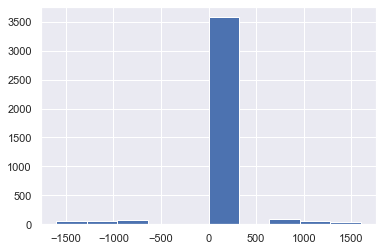

In [16]:
other['education-num'].hist()

In [17]:
tidy = MyTidy()
personal = tidy.tidy_personal(personal)
other = tidy.tidy_other(other)

## personal_train po cisteni
<ul>
    <li>stlpec 'Unnamed 0:' sme dropli</li>
    <li>delimitre sme zjednotili na jeden delimiter a nasledne sme podla neho rozdelili tento stlpec na tri stlpce 'street', 'city' a 'postal_code'</li>
    <li>datumy sme zjednotili na jednotny format yyyy-mm-dd</li>
    <li>zistili sme, ze pri adresach na namornickych lodiach a pod. po rozdeleni nebola vyplnena hodnota v stlpci 'city', vyplnili sme ich najfrekventovanejsou hodnotou</li>
    <li>pridali sme stlpec 'city_was_nan' v ktorom si pamatame v ktorych riadkoch nebola vyplnena hodnota stlpca 'city'</li>
    
</ul>

In [18]:
personal

,name,age,sex,date_of_birth,street,city,postal_code,city_was_nan
0,Roscoe Bohannon,32,Female,1987-07-22,7183 Osborne Ways Apt. 651,East Andrew,OH 53211,0.0
1,Ernest Kline,55,Male,1963-10-27,391 Ball Road Suite 961,Flowersborough,IN 57550,0.0
2,Harold Hendriks,62,Male,1957-10-05,8702 Vincent Square,New Jerryfurt,CO 30614,0.0
3,Randy Baptiste,47,Male,1972-06-29,2751 Harris Crossroad,West Ashley,CA 30311,0.0
4,Anthony Colucci,52,Female,1967-08-15,904 Robert Cliffs Suite 186,West Kyle,CO 77139,0.0
5,Ronald Lange,47,Female,1971-12-23,30973 Martinez Shores,Jameston,CA 70245,0.0
6,Boyd Eiselein,58,Male,1961-05-26,29941 Christopher Curve Apt. 682,Raychester,VA 32742,0.0
7,Raymond Smith,67,Male,1952-05-25,53487 Scott Extensions Apt. 824,Mccartytown,MA 94793,0.0
8,Harold Miller,43,Male,1976-09-15,8514 Elizabeth Crescent,West Joseland,GA 49359,0.0
9,Charles Czachorowski,62,Female,1957-10-06,6798 Wagner Locks Suite 377,Lake Brenda,DC 53038,0.0


## other_train po cisteni
<ul>
    <li>stlpec 'Unnamed0:' sme dropli</li>
    <li>duplicitne riadky sme spojili, tym padom nam ostalo ovela menej nulovych hodnot</li>
    <li>stlpec 'education-num' obsahuje spravne hodnoty</li>
    <li>taktiez sme rozdelili adresy ako v personal_train, vyplnili sme chybajuce hodnoty v stlpci 'city' najfrekventovanejsou hodnotou a pridali sme stlpec 'city_was_nan', ktory si pamata v ktorych riadkoch neboli vyplnene hodnoty</li>
    <li>zjednotili sme stlpec 'personal_info' na jeden delimiter a rozdelili sme ho na 5 stlpcov 'job', 'country', 'status', 'employment', 'race'</li>
    <li>hodnoty v stlpci v 'pregnant' sme nahradili bool hodnotami</li>
    <li>v stlpcoch 'job', 'country', 'employment', 'race' sme mali otazniky alebo string 'nan' a nahradili sme ich nan hodnotami</li>
    <li>v stplci 'job' sme mali nekonzistentne data, medzi dvoma slovami v stringu sa nachadzala pomlcka alebo podtrznik, pomlcky sme nahradili podtrznikmi</li>
    <li>v stlpcoch 'education', 'relationship' a 'income' sme odstranili medzeru pred slovom</li>
    </ul>

In [19]:
other

,name,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,mean_glucose,std_oxygen,capital-gain,skewness_oxygen,...,capital-loss,street,city,postal_code,job,country,status,employment,race,city_was_nan
0,George Kidd,5.991010,False,13.0,Own-child,5.185332,90.367188,30.878848,0.0,36.560536,...,0.0,481 Jenkins Branch Suite 358,Solistown,FL 83990,Craft_repair,United-States,Never-married,Private,White,0.0
1,Tommy Prince,2.124187,False,-1300.0,Husband,-0.521835,120.882812,62.780618,15024.0,3.307998,...,0.0,123 Sullivan Loaf,Cynthiaview,RI 22106,Exec_managerial,United-States,Married-civ-spouse,Private,White,0.0
2,Ivan Lane,22.432206,False,9.0,Own-child,0.751713,166.554688,9.733834,0.0,532.681562,...,0.0,509 Harris Hill,South Jean,IN 15542,Adm_clerical,United-States,Never-married,Private,White,0.0
3,Mack Sanchez,11.077929,False,13.0,Not-in-family,-0.029883,125.023438,17.771415,0.0,125.374683,...,0.0,8651 Destiny Shoal Suite 194,Codybury,HI 22805,Handlers_cleaners,Haiti,Never-married,Private,Asian-Pac-Islander,0.0
4,Francis Siebert,1.103161,False,11.0,Unmarried,15.720257,30.859375,64.290446,0.0,0.564051,...,0.0,982 Douglas Lights,Stewartfort,WY 59574,Other_service,Columbia,Divorced,Private,White,0.0
5,Jimmy Lewis,7.273688,False,10.0,Own-child,0.619718,107.351562,22.365407,0.0,55.690903,...,0.0,30822 Jorge Skyway Suite 941,South Andrea,GA 86694,Adm_clerical,United-States,Never-married,Private,White,0.0
6,Johnny Pham,5.014886,False,9.0,Not-in-family,13.135047,37.664062,27.562028,0.0,29.183754,...,0.0,2227 Bray Island,Lake Betty,AZ 96956,Machine_op_inspct,United-States,Never-married,Private,White,0.0
7,Jimmie Ralston,0.259073,False,900.0,Own-child,25.066518,38.492188,77.060088,0.0,-0.887048,...,0.0,3391 Deanna Loaf,Ibarraview,CA 89732,Farming_fishing,United-States,Never-married,Private,White,0.0
8,Lynn Quist,0.094011,False,9.0,Not-in-family,28.675575,27.367188,76.742368,0.0,-0.930389,...,0.0,2232 Flores Ridge,Sanchezstad,IL 31455,Machine_op_inspct,United-States,Divorced,Private,White,0.0
9,Arthur Osei,6.973065,False,800.0,Husband,-0.071847,126.406250,23.608844,0.0,52.172082,...,0.0,98834 James Turnpike Apt. 477,Port Nicole,MA 56324,Transport_moving,United-States,Married-civ-spouse,Private,White,0.0


## Nahradzanie nulovych hodnot

## Relationship
<ul>
    <li>v stplci 'relationship' sa nachadza 1 nulova hodnota</li>
    <li>budeme ju nahradzat najfrekventovanejsou na zaklade stlpca 'status'</li>
    <li>kedze v stlpci 'relationship' sa nachadza iba jedna nulova hodnota a v stlpci 'status' je hodnota 'Widowed' pozerame sa iba na najcastejsie vyskytujucu sa hodnotu v tomto pripade</li>
</ul>

In [20]:
other[other['relationship'].isnull()]

,name,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,mean_glucose,std_oxygen,capital-gain,skewness_oxygen,...,capital-loss,street,city,postal_code,job,country,status,employment,race,city_was_nan
2630,Joseph Rodriguez,3.489611,False,11.0,NaN,-0.536461,110.890625,51.607653,0.0,11.005832,...,2339.0,558 Mcdaniel Fields Suite 152,Mooreland,ME 15429,NaN,United-States,Widowed,NaN,White,0.0


<ul>
    <li>z grafu vidime, ze najcastejsia hodnota pri 'Widowed' je 'Not-in-family'</li>
</ul>

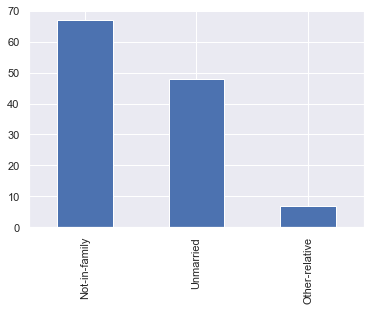

In [21]:
other.loc[other['status'] == 'Widowed', 'relationship'].value_counts().plot.bar()

## Education
<ul>
    <li>v stplci 'education' sa nachadza taktiez len 1 nulova hodnota</li>
    <li>budeme ju nahradzat najfrekventovanejsou na zaklade stlpca 'education-num'</li>
    <li>hodnota a v stlpci 'education-num' je '11' pozerame sa iba na najcastejsie vyskytujucu sa hodnotu v tomto pripade</li>
</ul>

In [22]:
other.loc[other['education'].isnull(), ['education', 'education-num']]

,education,education-num
2022,NaN,11.0


<ul>
    <li>tu sa nachadza iba jedna hodnota, 'Assoc-voc'</li>
</ul>

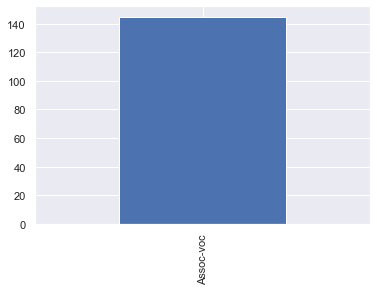

In [23]:
other.loc[other['education-num'] == 11.0, 'education'].value_counts().plot.bar()

## Employment
<ul>
    <li>nahradime najfrekventovanejsou hodnotou, pretoze maju nulove hodnoty aj v stlpci 'job'</li>
</ul>

In [24]:
other[other['employment'].isnull()]

,name,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,mean_glucose,std_oxygen,capital-gain,skewness_oxygen,...,capital-loss,street,city,postal_code,job,country,status,employment,race,city_was_nan
83,Benjamin Tinker,8.558328,False,13.0,Husband,0.229545,111.375000,15.774848,7688.0,94.066820,...,0.0,959 Stephen Gateway Apt. 342,Lake Cynthia,WA 57987,NaN,United-States,Married-civ-spouse,NaN,White,0.0
98,Marvin Cherry,15.186406,False,8.0,Own-child,0.397929,110.664062,10.756498,0.0,294.920170,...,0.0,75326 Odom Drive,North Robert,SC 99612,NaN,United-States,Never-married,NaN,White,0.0
123,Howard Fassino,6.326999,False,13.0,Not-in-family,0.275249,118.992188,27.399601,0.0,40.616556,...,0.0,18402 Sandra Knoll,Jamesside,OH 65316,NaN,United-States,Widowed,NaN,White,0.0
127,Timothy Gerth,10.757831,False,7.0,Not-in-family,0.598783,97.843750,13.179540,0.0,152.315306,...,0.0,27183 Roy Street,North Aprilport,LA 88338,NaN,United-States,Never-married,NaN,NaN,0.0
151,Jose Hendrick,4.702130,False,9.0,Wife,-0.170853,126.046875,36.950157,0.0,21.100617,...,0.0,25859 Wells Crest,East Saraview,MO 78455,NaN,United-States,Married-civ-spouse,NaN,White,0.0
171,Craig Newman,9.137269,False,4.0,Husband,1.128138,94.156250,16.883297,0.0,100.764628,...,0.0,61951 Gutierrez Falls,East Amyhaven,SD 72728,NaN,United-States,Married-civ-spouse,NaN,White,0.0
176,Russell Maynard,8.111663,False,900.0,Not-in-family,-0.181679,127.757812,20.721138,0.0,76.245456,...,0.0,5933 Elizabeth Falls,New Melissaland,MI 92779,NaN,United-States,Widowed,NaN,White,0.0
184,Hector Ramirez,1.908002,False,9.0,Not-in-family,10.988138,62.656250,56.464582,0.0,2.859559,...,0.0,4508 Morgan Light Suite 210,Port Rachel,CT 31884,NaN,United-States,Divorced,NaN,White,0.0
197,Dale Steppe,14.442101,False,9.0,Not-in-family,1.189221,105.250000,11.959234,0.0,253.234097,...,0.0,6816 Veronica Union Apt. 778,Bryanttown,HI 74222,NaN,United-States,Divorced,NaN,White,0.0
208,Alan Hawkinson,8.632358,False,10.0,Not-in-family,0.379537,113.054688,18.242808,0.0,85.512233,...,0.0,03769 Tiffany Lights Apt. 896,Parkerstad,OR 26074,NaN,United-States,Divorced,NaN,White,0.0


<ul>
    <li>z grafu vidime, ze najcastejsia vyskytujuca sa hodnota je 'Private'</li>
</ul>

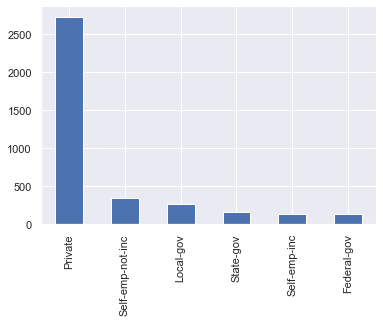

In [25]:
other['employment'].value_counts().plot.bar()

## Race
<ul>
    <li>nulove hodnoty nahradime najfrekventovanejsou hodnotou</li>
</ul>

In [26]:
other[other['race'].isnull()]

,name,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,mean_glucose,std_oxygen,capital-gain,skewness_oxygen,...,capital-loss,street,city,postal_code,job,country,status,employment,race,city_was_nan
11,Guy Guillory,22.149371,False,7.0,Husband,1.137467,92.804688,9.089983,0.0,555.272933,...,0.0,67619 Gates Crescent,North Laurenville,MA 47719,Transport_moving,United-States,Married-civ-spouse,Private,NaN,0.0
25,Edward Adams,9.232484,False,900.0,Unmarried,-0.469847,138.656250,14.691501,0.0,110.457895,...,0.0,34013 Ryan Park Suite 437,Smithside,OH 56416,Exec_managerial,United-States,Divorced,State-gov,NaN,0.0
28,Jack Patterson,5.924678,True,10.0,Wife,1.148864,99.851562,20.281290,0.0,40.878287,...,1977.0,35373 Ferguson Village,Williamsbury,VT 58918,Exec_managerial,United-States,Married-civ-spouse,Self-emp-not-inc,NaN,0.0
32,Lorenzo Thomas,10.596441,False,-1000.0,Own-child,-0.297782,115.468750,20.754115,0.0,113.930354,...,0.0,106 Gregory Port Suite 969,North Maxwelltown,MO 08225,Other_service,United-States,Never-married,Private,NaN,0.0
42,Alexander Bier,22.091694,False,6.0,Own-child,-0.474659,117.468750,8.827777,0.0,589.049037,...,0.0,43219 Michael Ports,Wadeland,HI 53498,Prof_specialty,United-States,Never-married,Private,NaN,0.0
47,Emery Gotay,12.218817,False,9.0,Husband,-0.158934,105.562500,12.206480,0.0,198.479672,...,0.0,8079 Scott Roads,Port Yvonne,OK 74115,Craft_repair,United-States,Married-civ-spouse,Self-emp-not-inc,NaN,0.0
76,Edward Bettes,7.151170,False,14.0,Husband,-0.053396,119.750000,21.181206,0.0,57.426060,...,0.0,38613 Melissa Throughway Apt. 413,Christianbury,GA 59790,Exec_managerial,United-States,Married-civ-spouse,Private,NaN,0.0
82,Michael Daniel,7.099364,False,9.0,Not-in-family,1.544753,89.437500,24.704737,0.0,52.461228,...,0.0,8814 Thompson Port,New Paul,KY 52304,Prof_specialty,United-States,Divorced,Private,NaN,0.0
100,Billy Rose,2.279081,False,9.0,Husband,32.437741,26.531250,51.357993,3103.0,5.406195,...,0.0,93411 Thompson Islands,West Krystal,NC 28075,Transport_moving,United-States,Married-civ-spouse,Private,NaN,0.0
101,Rickey Bell,16.053234,False,6.0,Husband,-0.363832,102.617188,10.386127,0.0,328.493271,...,0.0,USS Jones,NaN,FPO AE 94883,Other_service,United-States,Married-civ-spouse,Private,NaN,1.0


<ul>
    <li>z grafu vidime, ze najcastejsie vyskytujuca sa hodnota je 'White'</li>
</ul>

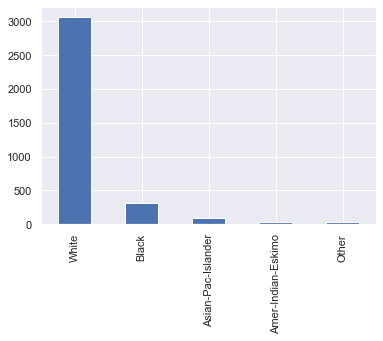

In [27]:
other['race'].value_counts().plot.bar()

## Job
<ul>
    <li>nulove hodnoty nahradzame najfrekventovanejsou hodnotou, pretoze v stlpci 'employment' sa nachadzaju nulove hodnoty</li>
</ul>

In [28]:
other[other['job'].isnull()]

,name,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,mean_glucose,std_oxygen,capital-gain,skewness_oxygen,...,capital-loss,street,city,postal_code,job,country,status,employment,race,city_was_nan
83,Benjamin Tinker,8.558328,False,13.0,Husband,0.229545,111.375000,15.774848,7688.0,94.066820,...,0.0,959 Stephen Gateway Apt. 342,Lake Cynthia,WA 57987,NaN,United-States,Married-civ-spouse,NaN,White,0.0
98,Marvin Cherry,15.186406,False,8.0,Own-child,0.397929,110.664062,10.756498,0.0,294.920170,...,0.0,75326 Odom Drive,North Robert,SC 99612,NaN,United-States,Never-married,NaN,White,0.0
123,Howard Fassino,6.326999,False,13.0,Not-in-family,0.275249,118.992188,27.399601,0.0,40.616556,...,0.0,18402 Sandra Knoll,Jamesside,OH 65316,NaN,United-States,Widowed,NaN,White,0.0
127,Timothy Gerth,10.757831,False,7.0,Not-in-family,0.598783,97.843750,13.179540,0.0,152.315306,...,0.0,27183 Roy Street,North Aprilport,LA 88338,NaN,United-States,Never-married,NaN,NaN,0.0
151,Jose Hendrick,4.702130,False,9.0,Wife,-0.170853,126.046875,36.950157,0.0,21.100617,...,0.0,25859 Wells Crest,East Saraview,MO 78455,NaN,United-States,Married-civ-spouse,NaN,White,0.0
171,Craig Newman,9.137269,False,4.0,Husband,1.128138,94.156250,16.883297,0.0,100.764628,...,0.0,61951 Gutierrez Falls,East Amyhaven,SD 72728,NaN,United-States,Married-civ-spouse,NaN,White,0.0
176,Russell Maynard,8.111663,False,900.0,Not-in-family,-0.181679,127.757812,20.721138,0.0,76.245456,...,0.0,5933 Elizabeth Falls,New Melissaland,MI 92779,NaN,United-States,Widowed,NaN,White,0.0
184,Hector Ramirez,1.908002,False,9.0,Not-in-family,10.988138,62.656250,56.464582,0.0,2.859559,...,0.0,4508 Morgan Light Suite 210,Port Rachel,CT 31884,NaN,United-States,Divorced,NaN,White,0.0
197,Dale Steppe,14.442101,False,9.0,Not-in-family,1.189221,105.250000,11.959234,0.0,253.234097,...,0.0,6816 Veronica Union Apt. 778,Bryanttown,HI 74222,NaN,United-States,Divorced,NaN,White,0.0
208,Alan Hawkinson,8.632358,False,10.0,Not-in-family,0.379537,113.054688,18.242808,0.0,85.512233,...,0.0,03769 Tiffany Lights Apt. 896,Parkerstad,OR 26074,NaN,United-States,Divorced,NaN,White,0.0


<ul>
    <li>z grafu vidime, ze najcastejsie vyskytujuca sa hodnota je 'Prof_speciality'</li>
</ul>

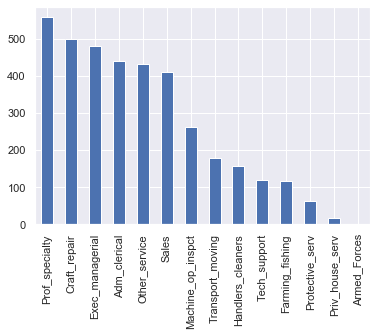

In [29]:
other['job'].value_counts().plot.bar()

## Country
<ul>
    <li>nahradzame najfrekventovanejsou hodnotou</li>
</ul>

In [30]:
other[other['country'].isnull()]

,name,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,mean_glucose,std_oxygen,capital-gain,skewness_oxygen,...,capital-loss,street,city,postal_code,job,country,status,employment,race,city_was_nan
66,Richard Traverso,11.310135,False,10.0,Own-child,0.457199,137.820312,15.719961,0.0,137.861039,...,0.0,2287 Kenneth Trace,Hernandezmouth,TN 82990,Adm_clerical,NaN,Never-married,Private,White,0.0
78,Sylvester Moore,-0.733793,False,13.0,Wife,12.492126,15.914062,56.965400,0.0,-0.072135,...,0.0,032 James Highway,Mendozatown,MS 09507,Adm_clerical,NaN,Married-civ-spouse,Self-emp-inc,White,0.0
81,Antonio Bailey,-0.935188,False,13.0,Husband,13.430837,16.125000,58.590543,0.0,0.261596,...,0.0,29028 Bowman Parkways,Kerrview,FL 57851,Sales,NaN,Married-civ-spouse,Private,White,0.0
134,Robert Mason,3.960912,False,3.0,Own-child,0.346604,129.968750,39.154487,0.0,14.843357,...,0.0,813 Austin Viaduct,Susanbury,RI 02382,Craft_repair,NaN,Never-married,Private,White,0.0
201,Randy Woo,9.973464,False,900.0,Not-in-family,-0.242293,128.937500,16.939858,0.0,112.590823,...,0.0,107 Kathleen Bridge,North Zacharystad,NJ 35105,Other_service,NaN,Never-married,Private,NaN,0.0
269,Daniel Thomas,1.893722,False,13.0,Husband,3.566892,75.171875,64.442520,0.0,2.244264,...,0.0,6493 Pena Greens,Lisafort,SD 14496,Exec_managerial,NaN,Married-civ-spouse,Private,White,0.0
302,Robert Reider,4.790492,False,14.0,Not-in-family,-0.273353,124.539062,36.615382,0.0,21.363304,...,0.0,70483 Parks Falls Suite 406,North Bradleymouth,DC 17187,Sales,NaN,Never-married,Private,White,0.0
341,Justin Sheppard,8.978112,False,16.0,Husband,0.012798,142.976562,15.639927,0.0,100.813474,...,0.0,974 Espinoza Mill,South Alex,IN 44036,Prof_specialty,NaN,Married-civ-spouse,Self-emp-inc,White,0.0
354,Bobby Gilbert,12.542178,False,8.0,Not-in-family,1.649471,85.742188,13.895042,0.0,171.061866,...,0.0,86727 Todd Shore,Sarahville,NE 34521,Transport_moving,NaN,Married-spouse-absent,Private,Black,0.0
358,William Morgan,0.270882,False,14.0,Not-in-family,24.705187,10.078125,68.089571,0.0,-1.018065,...,0.0,3522 Smith Springs Suite 888,South Alexandra,WY 59083,Prof_specialty,NaN,Never-married,Federal-gov,White,0.0


<ul>
    <li>z grafu vidime, ze najcastejsie vyskytujuca sa hodnota je 'United_States'</li>
</ul>

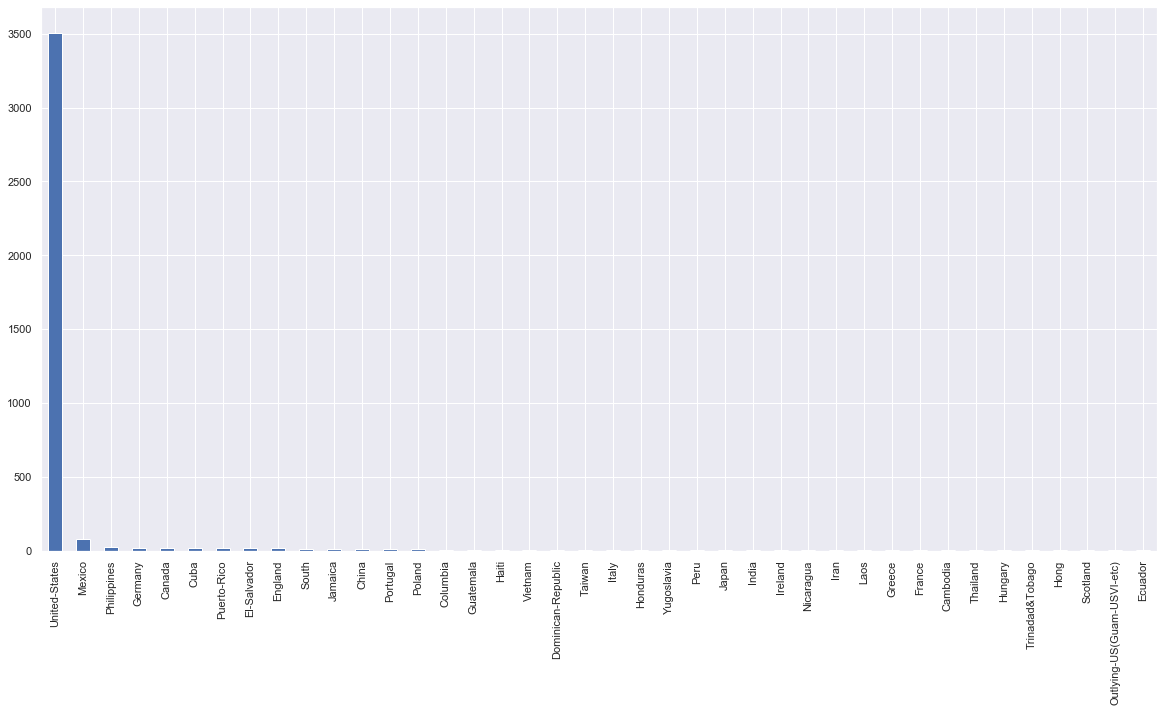

In [31]:
plt.figure(figsize = (20,10))
other['country'].value_counts().plot.bar()

## hours-per-week

<ul>
    <li>v stplci 'hours-per-week' sa nachadza taktiez len 1 nulova hodnota</li>
    <li>budeme ju nahradzat najfrekventovanejsou na zaklade stlpca 'employment'</li>
    <li>hodnota a v stlpci 'employment' je 'Private' pozerame sa iba na najcastejsie vyskytujucu sa hodnotu v tomto pripade</li>
</ul>

In [32]:
other[other['hours-per-week'].isnull()]

,name,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,mean_glucose,std_oxygen,capital-gain,skewness_oxygen,...,capital-loss,street,city,postal_code,job,country,status,employment,race,city_was_nan
1033,Ronald Hahn,8.207284,False,13.0,Husband,0.566602,131.132812,21.377515,0.0,71.573546,...,0.0,0780 Robert Ford Apt. 721,North Paulview,MA 94771,Exec_managerial,United-States,Married-civ-spouse,Private,White,0.0


<ul>
    <li>z grafu vidime, ze najcastejsia hodnota pri 'Private' je '40'</li>
</ul>

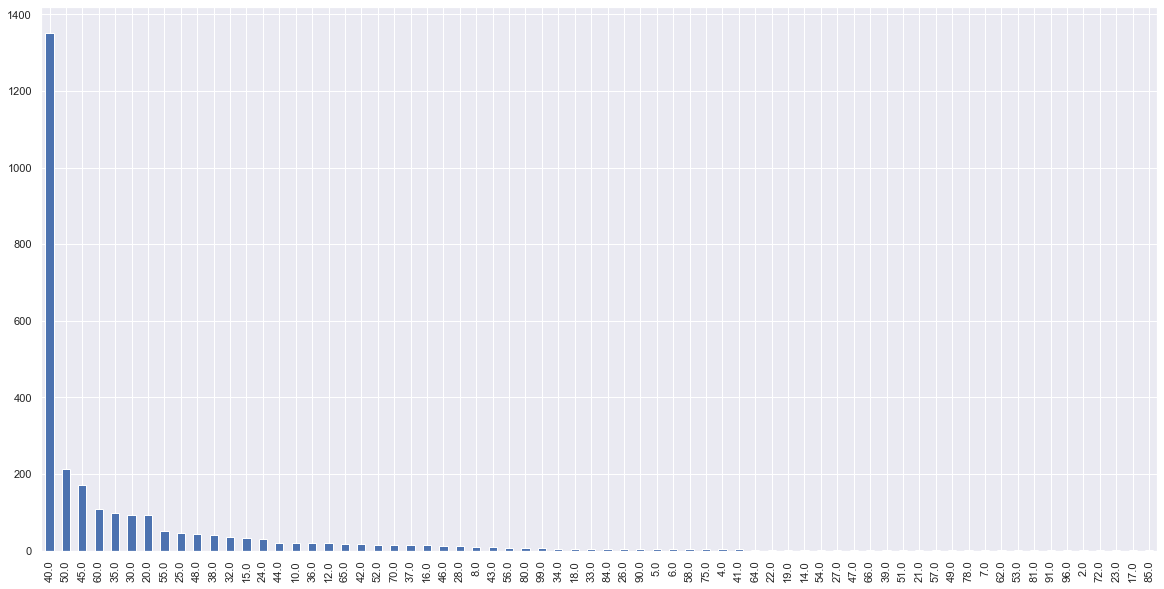

In [33]:
plt.figure(figsize = (20,10))
other.loc[other['employment'] == 'Private', 'hours-per-week'].value_counts().plot.bar()

## std_glucose
<ul>
    <li>kedze v tomto stlpci sa nachadza vela chybajucich hodnot tak na doplnenie pouzijeme linearnu regresiu</li>
    <li>zistili sme ze najsilnejsia korelacia s 'std_glucose' je so stlpcom 'mean_glucose', ktory si zvolime ako prediktor</li>

In [34]:
other.corr()

,kurtosis_oxygen,education-num,skewness_glucose,mean_glucose,std_oxygen,capital-gain,skewness_oxygen,kurtosis_glucose,fnlwgt,class,std_glucose,mean_oxygen,hours-per-week,capital-loss,city_was_nan
kurtosis_oxygen,1.000000,-0.003628,-0.477583,0.473401,-0.843476,0.011652,0.916904,-0.528772,-0.005442,-0.556919,0.249521,-0.661297,0.002913,0.010933,0.019449
education-num,-0.003628,1.000000,0.005586,-0.004236,0.013235,-0.039760,0.008231,0.007769,0.009953,0.004727,0.014597,0.011232,-0.011700,0.048559,0.005103
skewness_glucose,-0.477583,0.005586,1.000000,-0.826683,0.556958,-0.017568,-0.311990,0.962124,-0.006481,0.681506,-0.665065,0.549088,0.020483,-0.006027,-0.008802
mean_glucose,0.473401,-0.004236,-0.826683,1.000000,-0.560162,0.023462,0.308531,-0.925968,-0.000957,-0.774910,0.643027,-0.542133,-0.024969,0.015679,0.006180
std_oxygen,-0.843476,0.013235,0.556958,-0.560162,1.000000,-0.013181,-0.605601,0.619581,0.016348,0.648796,-0.275809,0.801655,-0.007095,-0.007911,-0.006467
capital-gain,0.011652,-0.039760,-0.017568,0.023462,-0.013181,1.000000,0.008091,-0.021160,-0.010173,0.002108,0.005120,-0.026952,0.072904,-0.030452,0.005623
skewness_oxygen,0.916904,0.008231,-0.311990,0.308531,-0.605601,0.008091,1.000000,-0.347074,-0.003702,-0.391416,0.191227,-0.396874,0.001563,0.011447,0.021798
kurtosis_glucose,-0.528772,0.007769,0.962124,-0.925968,0.619581,-0.021160,-0.347074,1.000000,-0.001896,0.788649,-0.651491,0.593700,0.021447,-0.012954,-0.008266
fnlwgt,-0.005442,0.009953,-0.006481,-0.000957,0.016348,-0.010173,-0.003702,-0.001896,1.000000,0.008829,0.006932,0.014963,0.000504,0.019629,0.000961
class,-0.556919,0.004727,0.681506,-0.774910,0.648796,0.002108,-0.391416,0.788649,0.008829,1.000000,-0.500004,0.516880,0.009589,-0.000948,-0.019304


<ul>
    <li>graf nam znazornuje, ze je mozne pouzit linearnu regresiu</li>
 </ul>

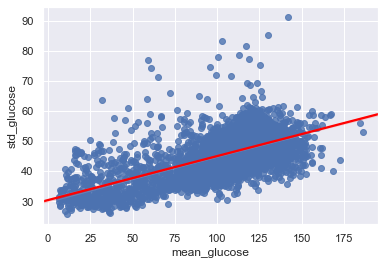

In [35]:
sns.regplot(data=other, x='mean_glucose', y='std_glucose', line_kws={'color': 'red'})

## Ostatne numericke atributy

<ul>
    <li>nulove hodnty sme nahradzali medianom, pretoze ich bolo malo v kazdom stlpci</li>
 </ul>

In [36]:
other.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3933 entries, 0 to 3932
Data columns (total 28 columns):
name                3933 non-null object
kurtosis_oxygen     3933 non-null float64
pregnant            3933 non-null object
education-num       3933 non-null float64
relationship        3932 non-null object
skewness_glucose    3933 non-null float64
mean_glucose        3933 non-null float64
std_oxygen          3932 non-null float64
capital-gain        3932 non-null float64
skewness_oxygen     3933 non-null float64
kurtosis_glucose    3931 non-null float64
education           3932 non-null object
fnlwgt              3933 non-null float64
class               3933 non-null float64
std_glucose         3540 non-null float64
income              3933 non-null object
mean_oxygen         3932 non-null float64
hours-per-week      3932 non-null float64
capital-loss        3932 non-null float64
street              3933 non-null object
city                3657 non-null object
postal_code       

In [37]:
imp = MyImputer()
personal = imp.fit_transform(personal.copy())
imp = MyImputer()
other = imp.fit_transform(other.copy())

C:\Users\Danie\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Danie\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Danie\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Po doplneni nulovych hodnot

<ul>
    <li>ako vidime vsetky hodnoty su doplnene</li>
</ul>

In [38]:
other.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3933 entries, 0 to 3932
Data columns (total 28 columns):
name                3933 non-null object
kurtosis_oxygen     3933 non-null float64
pregnant            3933 non-null bool
education-num       3933 non-null float64
relationship        3933 non-null object
skewness_glucose    3933 non-null float64
mean_glucose        3933 non-null float64
std_oxygen          3933 non-null float64
capital-gain        3933 non-null float64
skewness_oxygen     3933 non-null float64
kurtosis_glucose    3933 non-null float64
education           3933 non-null object
fnlwgt              3933 non-null float64
class               3933 non-null float64
std_glucose         3933 non-null float64
income              3933 non-null object
mean_oxygen         3933 non-null float64
hours-per-week      3933 non-null float64
capital-loss        3933 non-null float64
street              3933 non-null object
city                3933 non-null object
postal_code         

# Normalizacia - pred

## kurtosis_oxygen

<ul>
     <li>vidime, ze obsahuje vychylene hodnoty</li>
     <li>z grafu vidime, ze rozdelenie sa priblizuje k normalovemu rozdeleniu</li>
     <li>vychylene hodnoty budeme preto normalizovat hranicnymi hodnotami rozdelenia</li>
</ul>

In [39]:
stats.skew(other['kurtosis_oxygen'])

0.600736515174162

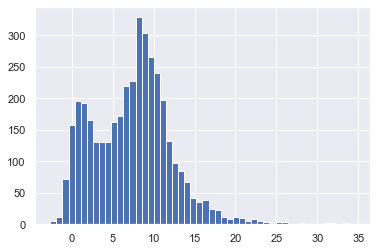

In [40]:
other['kurtosis_oxygen'].hist(bins=50)


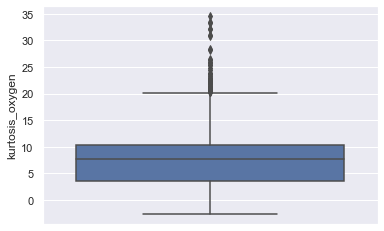

In [41]:
sns.boxplot(other['kurtosis_oxygen'], orient='v')

## skewness_glucose

<ul>
     <li>vidime, ze taktiez obsahuje vychylene hodnoty</li>
    <li>z grafu je evidentne, ze rozdelenie nie je normalove, preto hodnoty transformujeme pomocou logaritmu</li>
</ul>

In [42]:
stats.skew(other['skewness_glucose'])

2.874528025034139

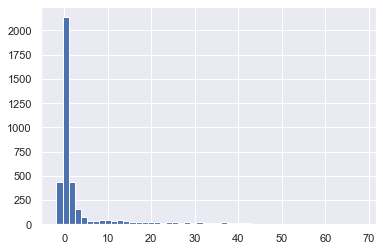

In [43]:
other['skewness_glucose'].hist(bins = 50)

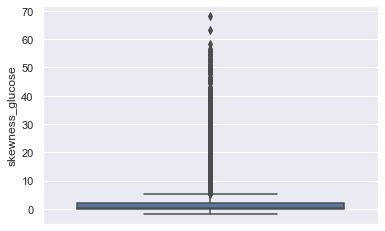

In [44]:
sns.boxplot(other['skewness_glucose'], orient='v')

## mean_glucose

<ul>
     <li>vidime, ze obsahuje vychylene hodnoty</li>
     <li>z grafu vidime, ze rozdelenie sa priblizuje k normalovemu rozdeleniu</li>
     <li>vychylene hodnoty budeme preto normalizovat hranicnymi hodnotami rozdelenia</li>
</ul>

In [45]:
stats.skew(other['mean_glucose'])

-1.0429122492722236

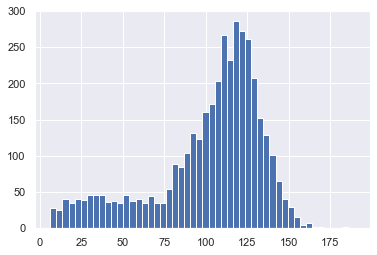

In [46]:
other['mean_glucose'].hist(bins = 50)

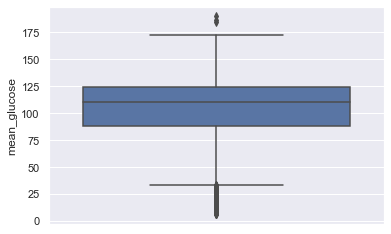

In [47]:
sns.boxplot(other['mean_glucose'], orient='v')

## std_oxygen
<ul>
     <li>z grafu vidime, ze hodnoty nie su z normaloveho rozdelenia, preto pouzijeme na transformaciu vychylenych hodnot odmocninu</li>
</ul>

In [48]:
stats.skew(other['std_oxygen'])

1.2008954858025394

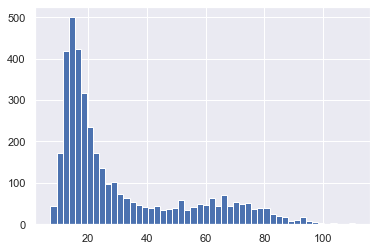

In [49]:
other['std_oxygen'].hist(bins = 50)

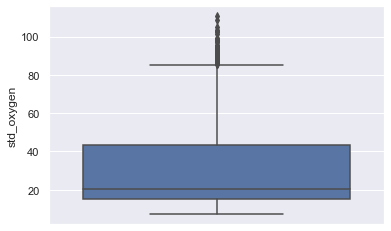

In [50]:
sns.boxplot(other['std_oxygen'], orient='v')

## skewness_oxygen
<ul>
     <li>z grafu vidime, ze hodnoty nie su z normaloveho rozdelenia, preto tiez pouzijeme na transformaciu vychylenych hodnot odmocninu</li>
</ul>

In [51]:
stats.skew(other['skewness_oxygen'])

3.1825059673719354

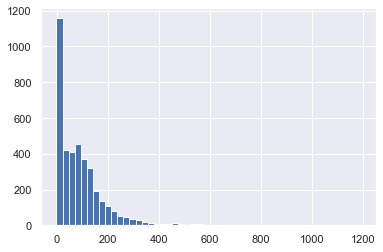

In [52]:
other['skewness_oxygen'].hist(bins = 50)

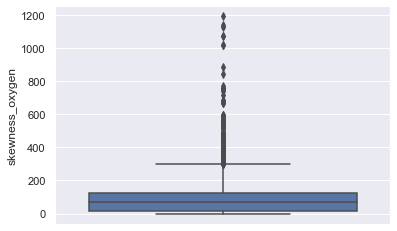

In [53]:
sns.boxplot(other['skewness_oxygen'], orient='v')

## kurtosis_glucose
<ul>
     <li>vidime, ze taktiez obsahuje vychylene hodnoty</li>
    <li>z grafu vieme vycitat, ze rozdelenie nie je normalove, preto hodnoty transformujeme pomocou logaritmu</li>
</ul>

In [54]:
stats.skew(other['kurtosis_glucose'])

2.0392178015205618

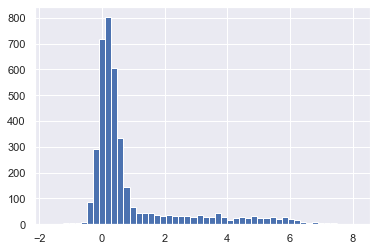

In [55]:
other['kurtosis_glucose'].hist(bins = 50)

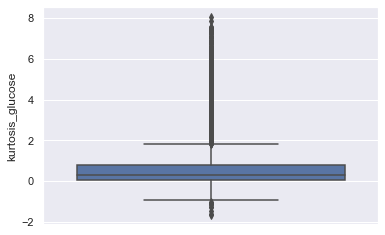

In [56]:
sns.boxplot(other['kurtosis_glucose'], orient='v')

## std_glucose

<ul>
    <li>v tomto pripade vidime, ze vychylenych hodnot je malo a preto nie je dolezite ich riesit</li>
</ul>

In [57]:
stats.skew(other['std_glucose'])

0.02005772289271505

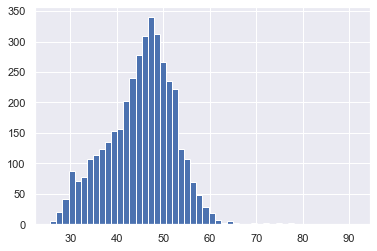

In [58]:
other['std_glucose'].hist(bins = 50)

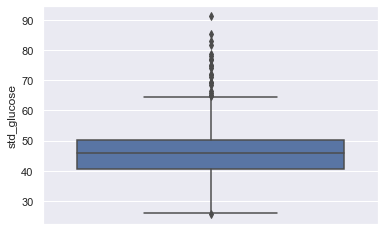

In [59]:
sns.boxplot(other['std_glucose'], orient='v')

## mean_oxygen
<ul>
     <li>obsahuje vychylene hodnoty</li>
    <li>z grafu vidime, ze rozdelenie nie je normalove, preto hodnoty tiez transformujeme pomocou logaritmu</li>
</ul>

In [60]:
stats.skew(other['mean_oxygen'])

2.6242871816432825

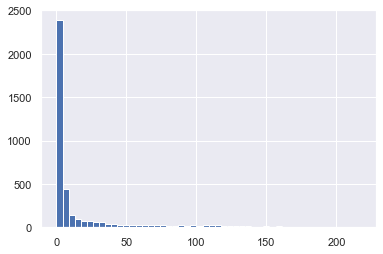

In [61]:
other['mean_oxygen'].hist(bins = 50)

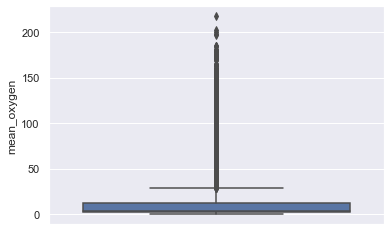

In [62]:
sns.boxplot(other['mean_oxygen'], orient='v')

In [63]:
normalizator = MyNormalizator()
other = normalizator.normalize(other.copy())

# Normalizacia - po a analyza numerickych atributov

## kurtosis_oxygen
<ul>
    <li>hodnoty su po normalizacii symetricke</li>
    <li>rozdelenie sa zmenilo, je viac normalove</li>
</ul>

In [64]:
stats.skew(other['kurtosis_oxygen'])

-0.021433761198845925

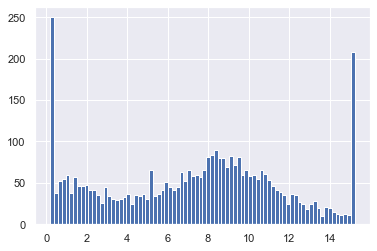

In [65]:
other['kurtosis_oxygen'].hist(bins=80)

<ul>
    <li>z grafu vidime, ze po normalizacii nie su ziadne vychylene hodnoty</li>
</ul>

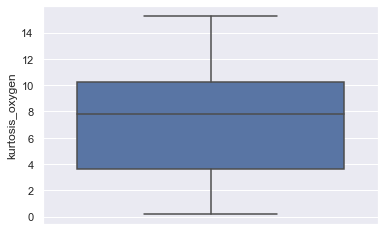

In [66]:
sns.boxplot(other['kurtosis_oxygen'], orient='v')

## skewness_glucose
<ul>
    <li>hodnota skew sa priblizila k nule, ale stale su hodnoty asymetricke</li>
    <li>rozdelenie sa zmenilo, viac sa podoba na normalove</li>
</ul>

In [67]:
stats.skew(other['skewness_glucose'])

1.6523415743670964

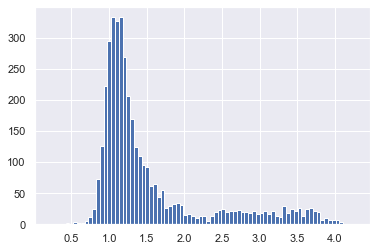

In [68]:
other['skewness_glucose'].hist(bins=80)

<ul>
    <li>ked si porovname boxplot pred normalizaciou a po tak vidime, ze niektore vychylene hodnoty uz nie su vychylenymi hodnotami</li>
 </ul>

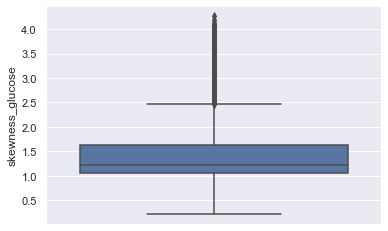

In [69]:
sns.boxplot(other['skewness_glucose'], orient='v')

## mean_glucose
<ul>
    <li>po nahradeni outlierov sa nic nezmenilo</li>
</ul>

In [70]:
stats.skew(other['mean_glucose'])

-1.0228360322450307

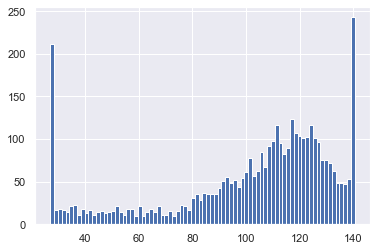

In [71]:
other['mean_glucose'].hist(bins=80)

<ul>
    <li>z grafu po normalizacii vidime, ze mame vyrazne menej vychylenych hodnot</li>
</ul>

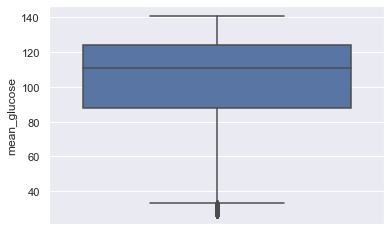

In [72]:
sns.boxplot(other['mean_glucose'], orient='v')

## std_oxygen
<ul>
    <li>z hodnoty skew vieme vycitat, ze hodnoty su symetricke</li>
    <li>po normalizacii sa rozdelenie nezmenilo</li>
</ul>

In [73]:
stats.skew(other['std_oxygen'])

0.9044365993557513

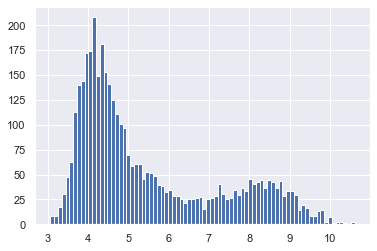

In [74]:
other['std_oxygen'].hist(bins=80)

<ul>
    <li>z grafu vidime, ze uz nemame ziadne vychylene hodnoty</li>
 </ul>

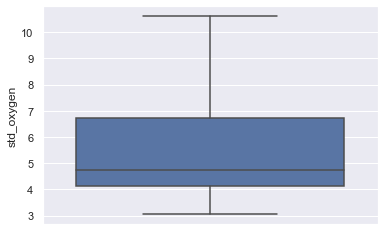

In [75]:
sns.boxplot(other['std_oxygen'], orient='v')

## skewness_oxygen
<ul>
    <li>hodnota skew nam hovori, ze hodnoty su symetricke</li>
    <li>po normalizacii sa rozdelenie viac podoba normalovemu rozdeleniu</li>
</ul>

In [76]:
stats.skew(other['skewness_oxygen'])

0.6327831308267557

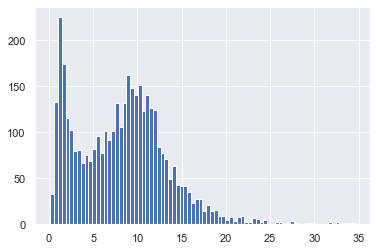

In [77]:
other['skewness_oxygen'].hist(bins=80)

<ul>
    <li>tu tiez vidime, ze vychylenych hodnot je menej</li>
</ul>

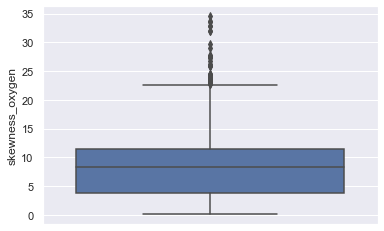

In [78]:
sns.boxplot(other['skewness_oxygen'], orient='v')

## kurtosis_glucose
<ul>
    <li>rozdelenie atributu sa nezmenilo, hodnota skew sa priblizila k nule, ale je stale asymetricke</li>
</ul>

In [79]:
stats.skew(other['kurtosis_glucose'])

1.5191311686240916

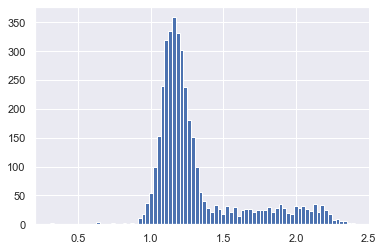

In [80]:
other['kurtosis_glucose'].hist(bins=80)

<ul>
    <li>vychylene hodnoty nad hornym fuzom ubudli, ale pod dolnym fuzom naopak pribudli</li>
 </ul>

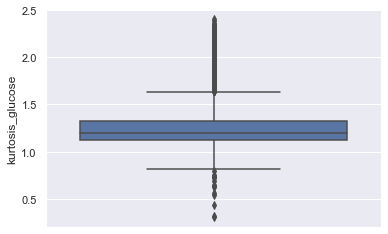

In [81]:
sns.boxplot(other['kurtosis_glucose'], orient='v')

## mean_oxygen

<ul>
    <li>aj ked sa hodnota skew posunula viac k 0, hodnoty su stale asymetricke</li>
    <li>graf znazornuje, ze hodnoty su viac sustredene okolo centra</li>
</ul>

In [82]:
stats.skew(other['mean_oxygen'])

1.309197754300456

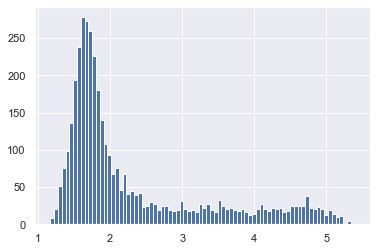

In [83]:
other['mean_oxygen'].hist(bins=80)

<ul>
    <li>vidime, ze vacsina vychylenych hodnot ubudla</li>
</ul>

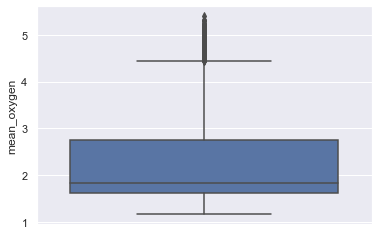

In [84]:
sns.boxplot(other['mean_oxygen'], orient='v')

## Analyza kategorickych atributov

<ul>
    <li>v oboch datasetoch nam pribudol novy atribut 'city_was_nan', aby sme si pamatali, kde bola nulova hodnota v stlpci 'city' po rozdeleni adresy, pretoze sme ich nahradzovali najfrekventovanejsou hodnotou</li>
    <li>0 predstavuje ze tam nebola nulova hodnota, 1 znazornuje ze tam bola</li>
    <li>z grafov mozeme vycitat, ze tam bolo malo nulovych hodnot</li>
</ul>

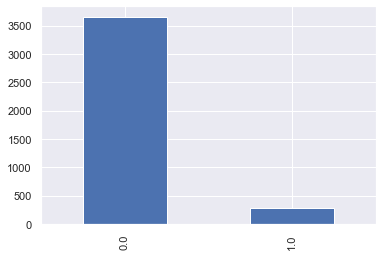

In [85]:
personal['city_was_nan'].value_counts().plot.bar()

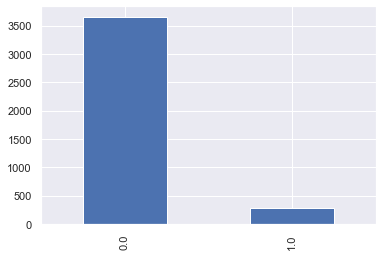

In [86]:
other['city_was_nan'].value_counts().plot.bar()

<ul>
    <li>kedze sme v stlpcoch 'job', 'employment', 'race' a 'country' NaN hodnoty nahradzali najfrekventovanejsou hodnotou sa tieto hodnoty navysili</li>
</ul>

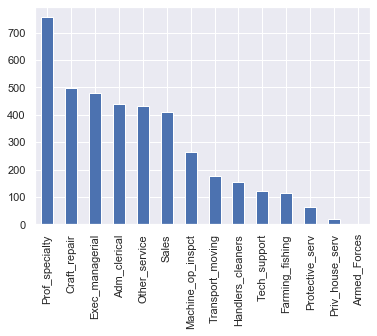

In [87]:
other['job'].value_counts().plot.bar()

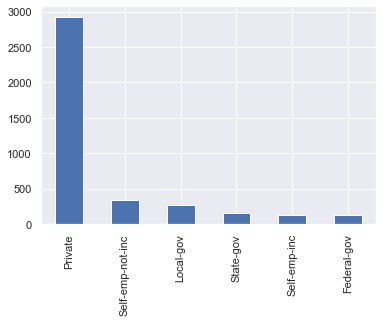

In [88]:
other['employment'].value_counts().plot.bar()

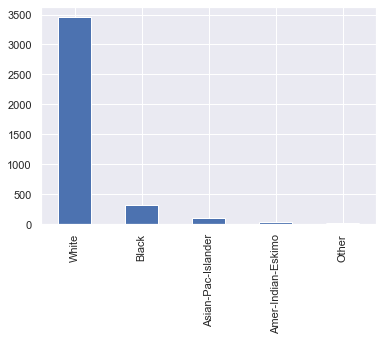

In [89]:
other['race'].value_counts().plot.bar()

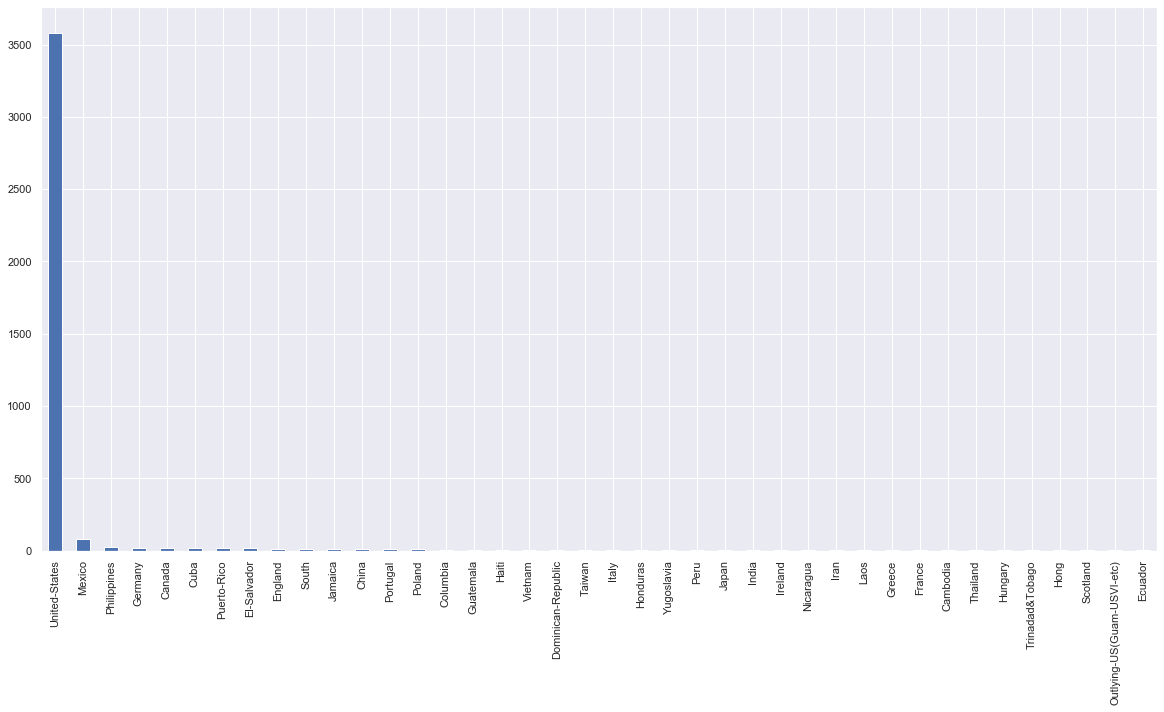

In [90]:
plt.figure(figsize=(20, 10))
other['country'].value_counts().plot.bar()

<ul>
    <li>po uprave zapornych cisel na kladne a vydelenim cislom 100 sa nam zmenila distribucia stlpca 'education-num'</li>
    <li>z grafu mozeme vycitat, ze najcastejsie vyskytujuca sa hodnota je 9</li>
</ul>

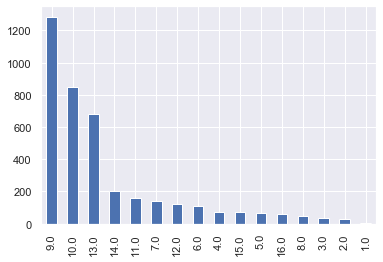

In [91]:
other['education-num'].value_counts().plot.bar()

## Spajanie datasetov
<ul>
    <li>'personal_train' a 'other_train' sme spojili podla mena</li>
    <li>duplicitne stlpce sme dropli</li>
</ul>

In [92]:
merger = MyMerger()
new = merger.merge(personal.copy(), other.copy())
new

,name,age,sex,date_of_birth,kurtosis_oxygen,pregnant,education-num,relationship,skewness_glucose,mean_glucose,...,capital-loss,street,city,postal_code,job,country,status,employment,race,city_was_nan
0,Roscoe Bohannon,32,Female,1987-07-22,9.221405,False,7.0,Own-child,1.092215,128.742188,...,0.0,7183 Osborne Ways Apt. 651,East Andrew,OH 53211,Other_service,United-States,Never-married,Private,White,0.0
1,Ernest Kline,55,Male,1963-10-27,4.034847,False,7.0,Husband,2.143209,86.539062,...,0.0,391 Ball Road Suite 961,Flowersborough,IN 57550,Other_service,United-States,Married-civ-spouse,Private,White,0.0
2,Harold Hendriks,62,Male,1957-10-05,8.257814,False,13.0,Husband,1.075085,130.070312,...,0.0,8702 Vincent Square,New Jerryfurt,CO 30614,Craft_repair,United-States,Married-civ-spouse,Private,White,0.0
3,Randy Baptiste,47,Male,1972-06-29,2.585330,False,12.0,Not-in-family,2.530467,68.789062,...,0.0,2751 Harris Crossroad,West Ashley,CA 30311,Sales,United-States,Never-married,Private,White,0.0
4,Anthony Colucci,52,Female,1967-08-15,2.878585,False,12.0,Wife,1.183175,103.398438,...,0.0,904 Robert Cliffs Suite 186,West Kyle,CO 77139,Tech_support,United-States,Married-civ-spouse,Private,White,0.0
5,Ronald Lange,47,Female,1971-12-23,0.202820,False,10.0,Own-child,2.587442,59.828125,...,0.0,30973 Martinez Shores,Jameston,CA 70245,Tech_support,United-States,Never-married,Private,White,0.0
6,Boyd Eiselein,58,Male,1961-05-26,0.443105,False,13.0,Unmarried,1.866816,89.429688,...,0.0,29941 Christopher Curve Apt. 682,Raychester,VA 32742,Sales,United-States,Never-married,Private,White,0.0
7,Raymond Smith,67,Male,1952-05-25,8.741603,False,7.0,Unmarried,1.172989,140.556250,...,0.0,53487 Scott Extensions Apt. 824,Mccartytown,MA 94793,Handlers_cleaners,United-States,Never-married,Private,White,0.0
8,Harold Miller,43,Male,1976-09-15,6.480177,False,9.0,Husband,1.033491,117.695312,...,0.0,8514 Elizabeth Crescent,West Joseland,GA 49359,Craft_repair,United-States,Married-civ-spouse,Private,White,0.0
9,Charles Czachorowski,62,Female,1957-10-06,2.330161,False,9.0,Own-child,0.977150,123.632812,...,0.0,6798 Wagner Locks Suite 377,Lake Brenda,DC 53038,Other_service,United-States,Never-married,Private,Black,0.0
